## Display function

In [1]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by=['fpr','tpr']).reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [2]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Function for filtering the result_list

In [3]:
import numpy as np
from sklearn.metrics import roc_curve
def filter_roc_results(results_list, results_original_roc, depth=1):
    """
    Filters the ROC results to include only those that are better than the original ROC curve.
    Each results_list item will compare its TPR against the original ROC curve's TPR at the same FPR.
    This function assumes that the results_list contains dictionaries with 'fpr', 'tpr' keys.
    If the TPR of a model at a given FPR is greater than the original model's TPR,
    it is considered a better model and included in the filtered results.
    If the FPR of a model is not present in the original ROC curve, then extrapolate
    the TPR value from the original ROC curve using linear interpolation.
    If the TPR of a model for a given FPR is equal to or worse than the original model's TPR, then
    we compute ROC results of the previous model in the list and compare the TPR with the original_model TPR for that FPR.
    If the above step still does not yield a better model, then we perform the same operation for the next model in the list.
    If still we do not find a better model, then we pick the original model as the best model for that FPR.
    The depth parameter defines how many models to look back and forward in the list
    to find a substitute model that performs better than the original model at the same FPR. 

    Args:
        results_list: A list of dictionaries containing the ROC results of the models.
        results_original_roc: A dictionary containing the ROC results of the original model.

    Returns:
        A filtered list of dictionaries containing only the relevant ROC results.
    """
    final_roc_points = []
    original_fprs = np.array(results_original_roc['fpr'])
    original_tprs = np.array(results_original_roc['tpr'])
    original_thresholds = np.array(results_original_roc['thresholds'])

    for i, current_data in enumerate(results_list):
        current_fpr = current_data["fpr"]
        current_tpr = current_data["tpr"]
        current_threshold = current_data["threshold"]

        original_tpr_at_current_fpr = np.interp(current_fpr, original_fprs, original_tprs)

        # 1. Is the current model's point better than the baseline?
        if current_tpr > original_tpr_at_current_fpr:
            final_roc_points.append({
                "model": current_data["model"],
                "fpr": current_fpr,
                "tpr": current_tpr,
                "threshold": current_threshold
            })
            continue

        # 2. NO. Search for the best substitute within the defined depth.
        best_substitute = None
        # Start by assuming the baseline is the best we can do. We need to beat this.
        best_substitute_tpr = original_tpr_at_current_fpr

        # Define the search window
        start_index = max(0, i - depth)
        end_index = min(len(results_list), i + depth + 1)

        for j in range(start_index, end_index):
            # Don't compare the model with itself
            if i == j:
                continue

            candidate_data = results_list[j]
            candidate_roc = candidate_data["full_roc"]
            
            # Find the candidate's performance at the current FPR
            candidate_tpr = np.interp(current_fpr, candidate_roc["fpr"], candidate_roc["tpr"])

            # If this candidate is the best substitute found so far...
            if candidate_tpr > best_substitute_tpr:
                best_substitute_tpr = candidate_tpr
                
                # ...find its corresponding threshold and store its info.
                idx = np.searchsorted(candidate_roc["fpr"], current_fpr)
                chosen_threshold = candidate_roc["thresholds"][max(0, idx - 1)]
                best_substitute = {
                    "model": candidate_data["model"],
                    "tpr": candidate_tpr,
                    "threshold": chosen_threshold
                }
        
        # 3. After searching, did we find a worthy substitute?
        if best_substitute:
            # YES. A substitute from the window was better than the baseline.
            best_substitute["fpr"] = current_fpr # Add the FPR to the dict
            final_roc_points.append(best_substitute)
        else:
            # NO. No model in the window was better. Fall back to the baseline.
            idx = np.searchsorted(original_fprs, current_fpr)
            chosen_threshold = original_thresholds[max(0, idx - 1)]
            final_roc_points.append({
                "model": "original_baseline",
                "fpr": current_fpr,
                "tpr": original_tpr_at_current_fpr,
                "threshold": chosen_threshold
            })

    # Find the min and max FPR values in the final results
    # if min FPR is greater than 0, use the operation points from 0 to min FPR of the model with the min FPR to fill the gap
    # we do the same for the max FPR less than 1
     # If no points were selected, return an empty list
    if not final_roc_points:
        return []

    # --- Start of the completed section ---

    # Find the point with the minimum FPR to start the curve
    min_fpr_point = min(final_roc_points, key=lambda x: x['fpr'])
    min_fpr_val = min_fpr_point['fpr']
    min_fpr_model_name = min_fpr_point['model']

    initial_points = []
    if min_fpr_val > 0:
        # Get the full ROC of the model with the minimum FPR
        if min_fpr_model_name == 'original_baseline':
            min_model_roc = results_original_roc
        else:
            min_model_data = next((item for item in results_list if item['model'] == min_fpr_model_name), None)
            min_model_roc = min_model_data['full_roc'] if min_model_data else None

        if min_model_roc:
            roc_fprs = np.array(min_model_roc['fpr'])
            roc_tprs = np.array(min_model_roc['tpr'])
            roc_thresholds = np.array(min_model_roc['thresholds'])
            
            indices_to_add = np.where(roc_fprs < min_fpr_val)[0]
            for idx in indices_to_add:
                initial_points.append({
                    "model": min_fpr_model_name,
                    "fpr": roc_fprs[idx],
                    "tpr": roc_tprs[idx],
                    "threshold": roc_thresholds[idx]
                })

    # Find the point with the maximum FPR to end the curve
    max_fpr_point = max(final_roc_points, key=lambda x: x['fpr'])
    max_fpr_val = max_fpr_point['fpr']
    max_fpr_model_name = max_fpr_point['model']
    
    trailing_points = []
    if max_fpr_val < 1.0:
        # Get the full ROC of the model with the maximum FPR
        if max_fpr_model_name == 'original_baseline':
            max_model_roc = results_original_roc
        else:
            max_model_data = next((item for item in results_list if item['model'] == max_fpr_model_name), None)
            max_model_roc = max_model_data['full_roc'] if max_model_data else None
        
        if max_model_roc:
            roc_fprs = np.array(max_model_roc['fpr'])
            roc_tprs = np.array(max_model_roc['tpr'])
            roc_thresholds = np.array(max_model_roc['thresholds'])

            indices_to_add = np.where(roc_fprs > max_fpr_val)[0]
            for idx in indices_to_add:
                trailing_points.append({
                    "model": max_fpr_model_name,
                    "fpr": roc_fprs[idx],
                    "tpr": roc_tprs[idx],
                    "threshold": roc_thresholds[idx]
                })

    # Combine all points
    combined_points = initial_points + final_roc_points + trailing_points

    # Sort by FPR (and then by descending TPR to keep the best point) and remove duplicates
    combined_points.sort(key=lambda p: (p['fpr'], -p['tpr']))
    
    unique_roc_points = []
    seen_fprs = set()
    for point in combined_points:
        if point['fpr'] not in seen_fprs:
            unique_roc_points.append(point)
            seen_fprs.add(point['fpr'])

    return unique_roc_points

## Data generation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1000
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 250
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)
        val_data = test_data
        
        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1000
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 250
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)
        val_data = test_data
        
        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Calculate Statistics function

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





## Data1: Quadratic Regression

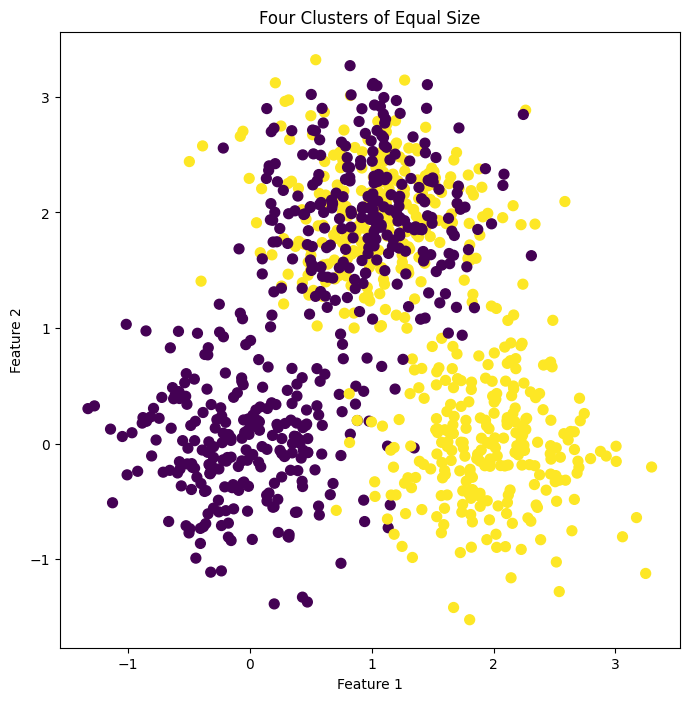

Training data shape: (800, 2), (800,)
Test data shape: (200, 2), (200,)


In [6]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc

train_data, test_data, val_data = generate_data("data2")

X_train = train_data[:, :-1]  # All columns except the last one
y_train = train_data[:, -1]   # Last column is the target variable

X_test = test_data[:, :-1]  # All columns except the last one
y_test = test_data[:, -1]   # Last column is the target variable

# Quadratic Discriminant Analysis
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)



# print('Mean squared error: ', np.mean((beta_star - beta_hat) ** 2))

#calculate ROC results
fpr_roc, tpr_roc, threshold_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
results_original_roc = {"fpr": fpr_roc, "tpr": tpr_roc, "thresholds": threshold_roc, "name": "Quadratic Discriminant Analysis", "auc": auc(fpr_roc, tpr_roc), "model": clf}



In [7]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc
# Weight the X_train and y_train for cost-sensitive learning
minority_class_weight = np.arange(0, 1, 0.001)
majority_class_weight = 1.0 - minority_class_weight
list_weighted_clfs = []
for w in minority_class_weight:
    #class_weights = {0: 1 - w, 1: w}
    priors_array = [1-w,w]
    clf_weighted = QuadraticDiscriminantAnalysis(priors=priors_array)
    clf_weighted.fit(X_train, y_train)

    res = get_fpr_tpr(clf_weighted, X_test, y_test, threshold=0.5)

    array_of_all_fprs, array_of_all_tprs, threshold_vals = roc_curve(y_test, clf_weighted.predict_proba(X_test)[:, 1])

    current_result = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "threshold": 0.5,
        "full_roc": {"fpr": array_of_all_fprs, "tpr": array_of_all_tprs, "thresholds": threshold_vals},
    }
    list_weighted_clfs.append(current_result)
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:976: RuntimeWarning: divide by zero encountered in log
  return -0.5 * (norm2 + u) + np.log(self.priors_)
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:976: RuntimeWarning: divide by zero encountered in log
  return -0.5 * (norm2 + u) + np.log(self.priors_)


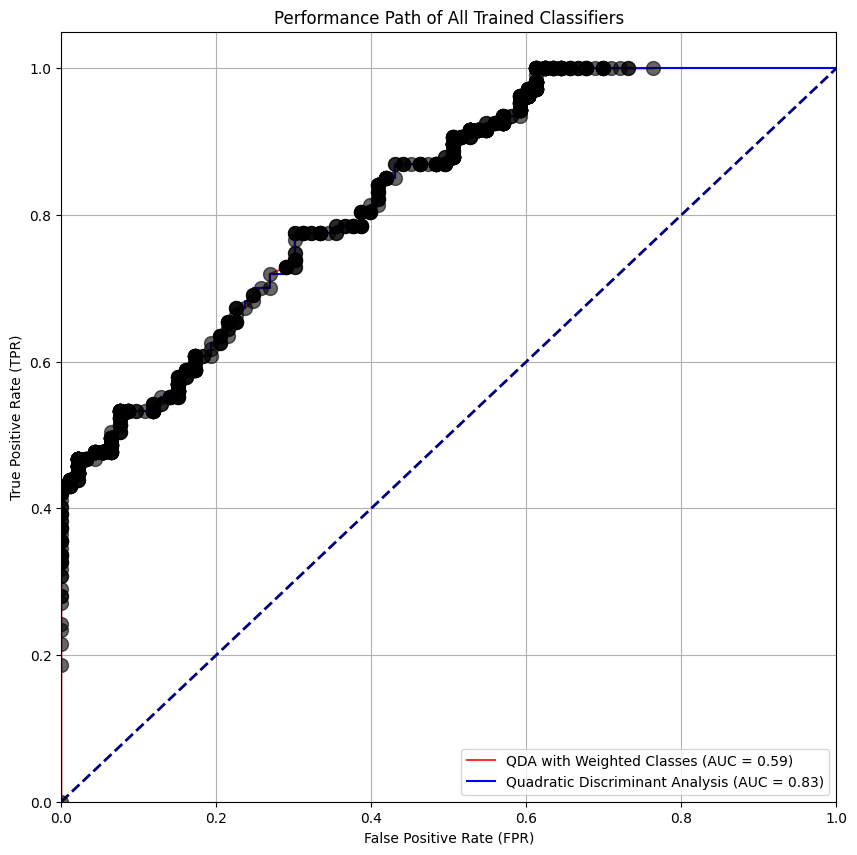

In [8]:
plot_roc_connected_points(list_weighted_clfs, results_original_roc, name="QDA with Weighted Classes")

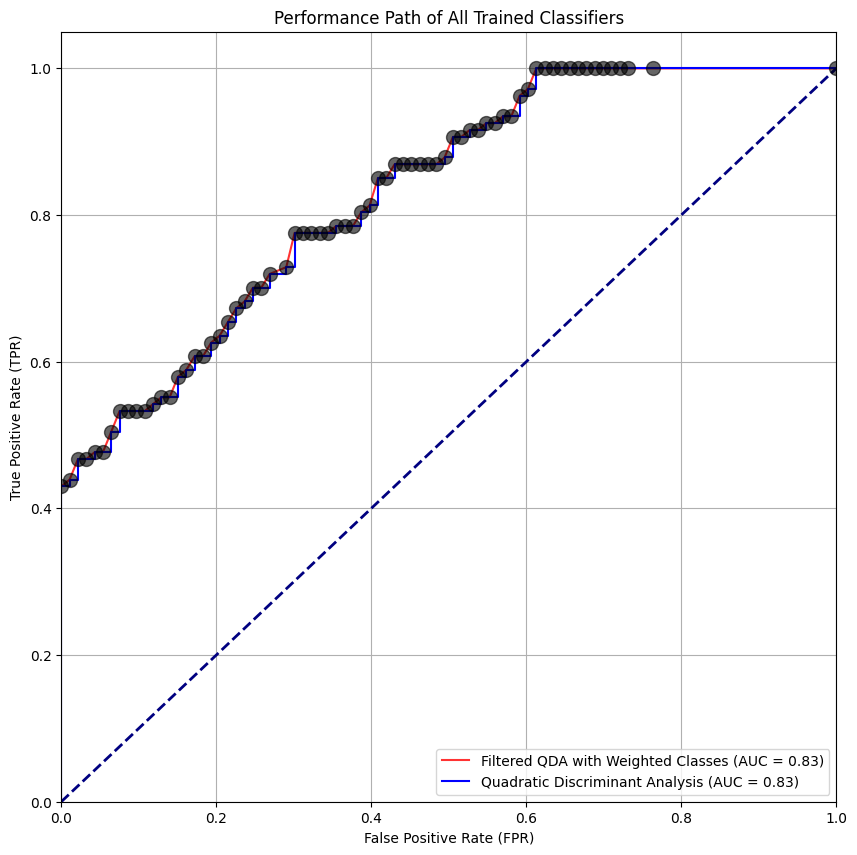

In [9]:
#filter the results
filtered_results = filter_roc_results(list_weighted_clfs, results_original_roc, depth=10)
# Plot the filtered results
plot_roc_connected_points(filtered_results, results_original_roc, name="Filtered QDA with Weighted Classes")

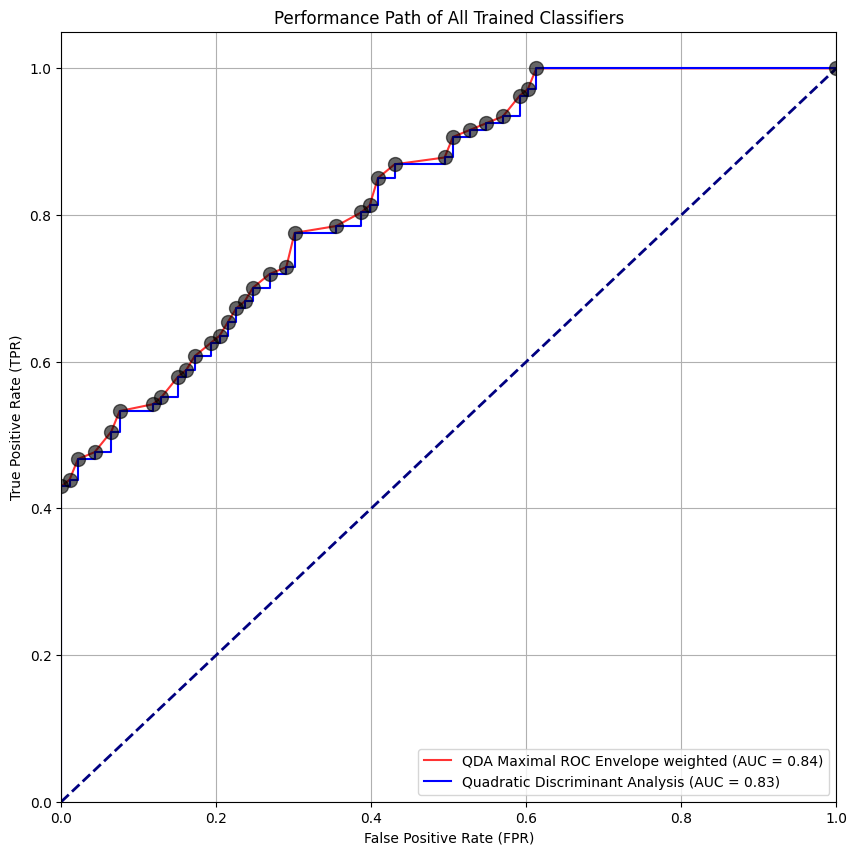

In [10]:
best_envelope = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
# Plot the best ROC envelope
plot_roc_connected_points(best_envelope, results_original_roc, name="QDA Maximal ROC Envelope weighted")